<div style="border:solid Chocolate 2px; padding: 40px">

<b> Елизавета, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
критичные ошибки, которые обязательно нужно исправить.
</div>

    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Привет, Алексей! Рада знакомству. Мои комментарии к исправлению будут выделены синим фоном.
</div>

# Анализ лояльности пользователей и динамики продаж билетов на платформе Яндекс Афиша (июнь - октябрь 2024)

* Автор: Путилина Елизавета Евгеньевна
* Дата: 17.10.2025

**Введение**

Команда маркетинга платформы Яндекс Афиша поставила перед собой цель: расширить клиентскую базу платформы Яндекс Афиша и стимулировать пользователей к повторным покупкам. Период данных: 1 июня – 31 октября 2024 года.

**Цель проекта** -  провести исследовательский анализ данных EDA, чтобы выявить ключевые тренды и сформировать рекомендации для улучшения работы сервиса.

**Задачи проекта:**
* Загрузка и предобработка данных;
* Построить агрегированные признаки, описывающие поведение и профиль каждого пользователя;
* Исследование признаков, влияющих на возврат пользователей;
* Формирование выводов и рекомендаций для команды маркетинга.

**Содержимое проекта:**
1. [Загрузка данных и знакомство с ними](#chapter1)
2. [Предобработка данных](#chapter2)
3. [Создание профиля пользователя](#chapter3)
4. [Исследовательский анализ данных](#chapter4)
5. [Общий вывод и рекомендации](#chapter5)
6. [Финализация проекта и публикация в Git](#chapter6)

---

## 1. Загрузка данных и знакомство с ними <a class="anchor" id="chapter1"></a>


**Задача 1.1:** Напишем SQL-запрос, выгружающий в датафрейм pandas необходимые данные.

Для выгрузки будем использовать библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

In [203]:
# Установим необходимые библиотеки для подключения к базе данных
!pip install sqlalchemy
!pip install psycopg2-binary

In [274]:
# Установим необходимые библиотеки для обработки данных
!pip install phik
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix
from sqlalchemy import create_engine 

     |████████████████████████████████| 677 kB 2.3 MB/s eta 0:00:01


In [205]:
!pip install python-dotenv
import os
import dotenv

# Получаем список всех файлов и папок в текущей директории
files_and_folders = os.listdir()

# Выводим список
print(files_and_folders)

dotenv.load_dotenv(dotenv_path="./local_config.env")
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)

In [206]:
# Создаем соединение с базой данных
engine = create_engine(connection_string)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали, коннектор сделали - отлично!

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> В версии, которую ты заливаешь на `GitHub`, не стоит оставлять параметры подключения в явном виде - это может привести к несанкционированному доступу к данным, что чревато их потереей или изменением. Лучшее решение - локально создать `.env` файл, из которого с помощью `os` эти параметры подключения передаются в код. А файл `.gitignore` поможет не отслеживать этот файл для репозитория.
    
Файл `.env` может выглядеть так:

```python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
```
    
В самом проекте мы можем обращаться к сохраненным параметрам с помощью библиотеки `dotenv`, чтобы загрузить переменные окружения, и `os`, чтобы обратиться к ним:
    
```python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)
```

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Загружены переменные окружения из файла local_config.env.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Обрати внимание, что это касалось только `GitHub` - в версии, которую ты отправляешь на ревью, параметры подключения нужно задать явно.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>
    
* Параметры подключения для ревью заданы явно;
    
* Для `GitHub`загружены переменные окружения из файла `local_config.env`.
</div>

In [207]:
# Пропишем запрос, выгружающий необходимую информацию из базы данных
query = '''
SELECT  user_id,
        device_type_canonical,
        order_id,
        created_dt_msk AS order_dt,
        created_ts_msk AS order_ts,
        currency_code,
        revenue,
        tickets_count,
        created_dt_msk::date - LAG(created_dt_msk::date) OVER(PARTITION BY user_id ORDER BY created_dt_msk)
AS days_since_prev,
        event_id,
        service_name,
        event_type_main,
        region_name,
        city_name        
FROM afisha.purchases AS p
JOIN afisha.events AS e USING(event_id)
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS re ON c.region_id = re.region_id
WHERE device_type_canonical IN ('mobile', 'desktop') AND event_type_main NOT IN ('фильм')
ORDER BY user_id;
''' 

In [208]:
# Запишем результат выдачи SQL-запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

# Выводим строки датафрейма на экран
display(df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,Прачечная,театр,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,Билеты без проблем,стендап,Широковская область,Ягодиновка


---

**Задача 1.2:** Изучим общую информацию о выгруженных данных.

In [209]:
# Выведем информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

**Промежуточный вывод**

Датасет `df` содержит 14 столбцов и 290611 строк, в которых представлена информация о клиентской базе платформы Яндекс Афиша. 

В ходе предварительной обработки данных (SQL) было выявлено, что пользователи чаще всего покупают билеты с мобильных устройств и 
стационарных компьютеров. Поэтому, другие устройства в ходе данного исследования не будут учитываться. Также, выручка `currency_code` представлена в российских рублях и казахстанских тенге, что необходимо учитывать при дальнейших расчётах.

Изучим типы данных и их корректность:

1. **Строковые данные (object).** В датасете представлено 7 столбцов с данными такого типа:
`user_id`, `device_type_canonical`, `currency_code`, `service_name`, `event_type_main`, `region_name`, `city_name` содержат строковую информацию. Тип данных `object` корректен;
2. **Числовые значения (int64).** В датасете представлены 3 столбца с данными такого типа:
`order_id`, `tickets_count`, `event_id`. Тип данных `int64` корректен;
3. **Числовые значения с плавающей запятой (float64).** В датасете представлено 2 столбца с данными такого типа:
* `revenue` - выручка от заказа. Тип данных `float64` корректен;
* `days_since_prev` - количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено. В данном столбце могут быть указаны неполные дни, поэтому тип `float64` здесь корректен. 
4. **Данные времени (datetime64).** В датасете представлено 2 столбца с данными такого типа:
* `order_dt` -  дата создания заказа;
* `order_ts` - время создания заказа.

Тип данных `datetime64` корректен.

В ходе анализа датасета `df` было выявлено, что в 1 из 14 столбцов (`days_since_prev`) есть пропуски. В данном столбце это означает, что пользователь совершил только одну покупку (оставим без изменений, чтобы избежать искажения данных).

Все типы данных представлены корректно.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные выгружены и изучены.

---

##  2. Предобработка данных  <a class="anchor" id="chapter2"></a>

* Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведем выручку к единой валюте — российскому рублю.

Для этого, используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраним в новый столбец `revenue_rub`.

In [210]:
# Загрузка данных о курсе тенге к рублю в датафрейм
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'

exchange_rate_df = pd.read_csv(url)

# Выведем датафрейм `exchange_rate_df` на экран
display(exchange_rate_df)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [211]:
# Функция конвертации
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] / 100 * exchange_rate_df['curs'].values[0]
    else:
        return row['revenue']

In [212]:
# Конвертируем тенге в рубли и сохраним результаты в новый столбец `revenue_rub` датафрейма `df`
df['revenue_rub'] = df.apply(convert_to_rub, axis = 1)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выручка приведена к единой валюте.
    
Отмечу, что `apply` неээфективен, так как построчно итерируется по каждой строке таблицы. 
    
Лучше использовать присваивание с помощью `loc`:
    
```python
rate_map = exchange_rates.set_index('data')['curs']
df['rate'] = df['order_dt'].map(rate_map)
df['revenue_rub'] = df['revenue']
mask = df['currency_code'] == 'kzt'
df.loc[mask, 'revenue_rub'] = df['revenue'] * df['rate'] / 100
```

In [213]:
# Проверяем разницу между валютами
print('Сравнение до и после конвертации:')
print(df[['currency_code', 'revenue', 'revenue_rub']].sort_values(by = ['currency_code'], ascending = True).head())

# Проверяем конвертацию для тенге
convert_to_tenge = df[df['currency_code'] == 'kzt']
print(f'\nКонвертировано {len(convert_to_tenge)} записей в тенге')

# Проверяем средний курс
if not convert_to_tenge.empty:
    avg_rate = (convert_to_tenge['revenue_rub'] / convert_to_tenge['revenue']).mean()
    print(f'\nСредний примененный курс: {avg_rate:.4f} руб за 1 тенге')

Сравнение до и после конвертации:
       currency_code   revenue  revenue_rub
83697            kzt  10338.19  2061.342042
175995           kzt   1849.41   368.755709
175997           kzt    414.43    82.633612
175998           kzt     82.19    16.387946
175999           kzt   1773.07   353.534200

Конвертировано 5069 записей в тенге

Средний примененный курс: 0.1994 руб за 1 тенге


* Проверим данные на пропущенные значения

In [214]:
# Посчитаем количество пропусков в каждом столбце в абсолютном значении
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [215]:
# Посчитаем количество пропусков в каждом столбце в относительном значении
round((df.isna().sum() / len(df)) * 100, 5)

user_id                  0.0000
device_type_canonical    0.0000
order_id                 0.0000
order_dt                 0.0000
order_ts                 0.0000
currency_code            0.0000
revenue                  0.0000
tickets_count            0.0000
days_since_prev          7.5472
event_id                 0.0000
service_name             0.0000
event_type_main          0.0000
region_name              0.0000
city_name                0.0000
revenue_rub              0.0000
dtype: float64

Пропуски есть только в столбце `days_since_prev` (7,6%). В данном столбце это означает, что пользователь совершил только одну покупку.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Пропуски проанализированы.

* Проверим уникальные значения в ключевых категориальных столбцах

In [216]:
# Анализ ключевых категориальных признаков
cat_columns_orders = ['device_type_canonical', 'currency_code', 'service_name', 'event_type_main', 'region_name', 'city_name']

for col in cat_columns_orders:
    print(f'Колонка: {col}')
    print(f'Количество уникальных значений: {df[col].nunique()}')
    print(f'Уникальные значения: {df[col].sort_values().unique()}\n')
    print('Распределение значений:')
    print(f'{df[col].value_counts(normalize = True, dropna = False)}')
    print(f'Пропусков: {df[col].isna().sum()}\n')

Колонка: device_type_canonical
Количество уникальных значений: 2
Уникальные значения: ['desktop' 'mobile']

Распределение значений:
mobile     0.800004
desktop    0.199996
Name: device_type_canonical, dtype: float64
Пропусков: 0

Колонка: currency_code
Количество уникальных значений: 2
Уникальные значения: ['kzt' 'rub']

Распределение значений:
rub    0.982557
kzt    0.017443
Name: currency_code, dtype: float64
Пропусков: 0

Колонка: service_name
Количество уникальных значений: 36
Уникальные значения: ['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Ш

В категориальных столбцах аномалии не обнаружены. Нормализация данных не требуется.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Категориальные признаки проверены на предмет аномалий.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Стоит использовать сортировку, чтобы найти аномалии регистра вроде `концерт` и `КОНЦЕРТ`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Учтено
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Кажется, нет - сортировку нужно делать перед выводом категорий на экран.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Результат нужно прокомментировать - есть ли что-то, на что нужно обратить внимание?

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Учтено
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Вывод нужно сделать с точки зрения наличия/отсутствия аномалий - сейчас ты просто комментируешь статистики.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

* Проверим датафрейм `df` на наличие явных дубликатов.

In [217]:
# Вычислим количество явных дубликатов
df.duplicated(keep = 'last').sum()

0

Явные дубликаты отсутствуют.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Явные дубликаты не найдены.

* Проверим датафрейм `df` на наличие не явных дубликатов по ключевым полям.

In [218]:
# Вычислим количество неявных дубликатов
col_duplicates = ['user_id', 'event_id', 'order_dt', 'tickets_count']
all_duplicates = df[df.duplicated(subset = col_duplicates, keep = False)]

print(f'Неявные дубликаты: {len(all_duplicates)}')

# Удаление неявных дубликатов, оставляем последнюю запись в группе
cleaned_df = df.drop_duplicates(subset = col_duplicates, keep = 'last')

# Проверка после удаления
remaining_duplicates = cleaned_df[cleaned_df.duplicated(subset = col_duplicates, keep = False)]
print(f'Остались неявные дубликаты после очистки: {len(remaining_duplicates)}')
print(f'Количество записей после очистки: {len(cleaned_df)}')
print(f'Процент удаленных дубликатов: {1 - len(cleaned_df)/len(df):.2%}')

Неявные дубликаты: 86455
Остались неявные дубликаты после очистки: 0
Количество записей после очистки: 237334
Процент удаленных дубликатов: 18.33%


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Молодец, что оцениваешь также неявные дубликаты. Полезно было бы также проверить без учёта `tickets_count` по связке выше.

* Проверим распределение и наличие выбросов в столбцах `revenue_rub` и `tickets_count`.

In [219]:
# Выведем метрики для столбцов `revenue_rub`
print('Статистические показатели для столбца revenue_rub:')
cleaned_df['revenue_rub'].describe()

Статистические показатели для столбца revenue_rub:


count    237334.000000
mean        567.018323
std         894.315851
min         -90.760000
25%         124.380000
50%         370.370000
75%         815.247500
max       81174.540000
Name: revenue_rub, dtype: float64

По результатам анализа данных столбца `revenue_rub` было выявлено:
* присутствует большая разница между медианой (370) и средним значением (567), что говорит о неравномерном распределении данных;
* большой размах данных и высокое стандартное отклонение говорят о большом разбросе данных;
* большие значения min(-90.8) и max(81174,5) указывают на наличие выбросов.  

In [220]:
# Выведем метрики для столбцов `tickets_count`
print('Статистические показатели для столбца tickets_count:')
cleaned_df['tickets_count'].describe()

Статистические показатели для столбца tickets_count:


count    237334.000000
mean          2.755147
std           1.173599
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

По результатам анализа данных столбца `tickets_count` было выявлено:

* присутствует небольшая разница между медианой (3,0) и средним значением (2,8), что говорит об относительно нормальном распределении данных;
* большой размах данных и большое максимальное значение max(57) указывают на наличие выбросов.

Построим визуализации распределения значений для столбцов `revenue_rub` и `tickets_count`.

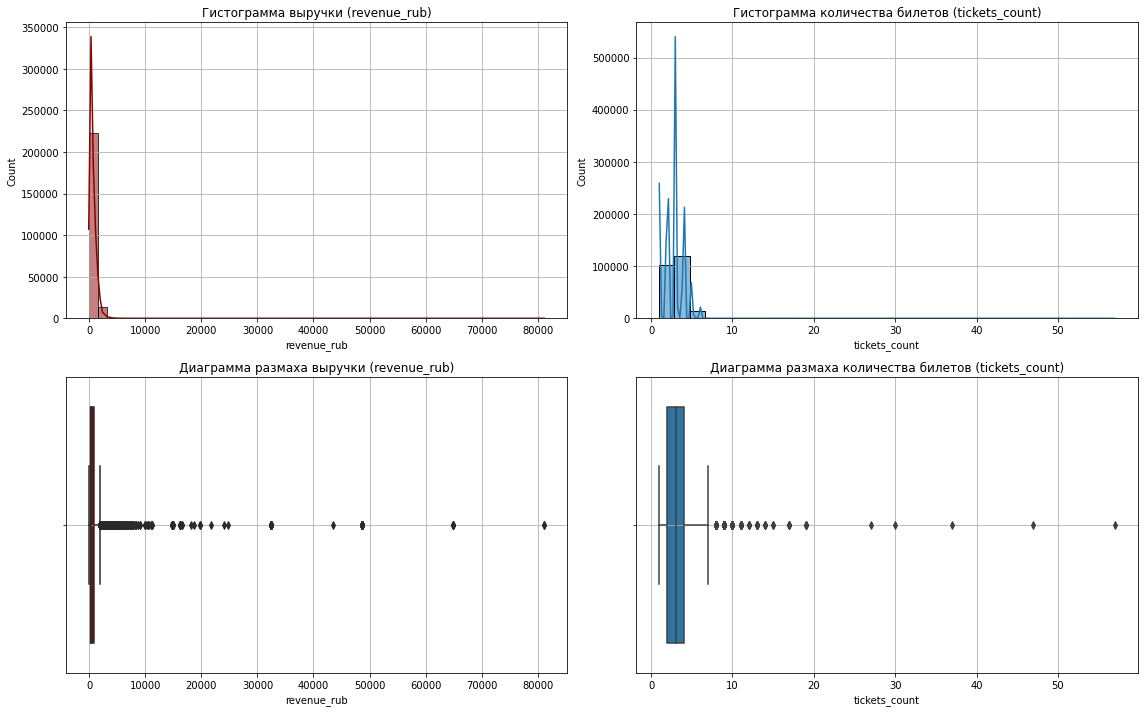

In [221]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `revenue_rub`
sns.histplot(cleaned_df['revenue_rub'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма выручки (revenue_rub)')
axes[0, 0].grid()

# Диаграмма размаха для `revenue_rub`
sns.boxplot(data = cleaned_df, x = 'revenue_rub', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха выручки (revenue_rub)')
axes[1, 0].grid()

# Гистограмма для `tickets_count`
sns.histplot(cleaned_df['tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма количества билетов (tickets_count)')
axes[0, 1].grid()

# Диаграмма размаха для `tickets_count`
sns.boxplot(data = cleaned_df, x = 'tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха количества билетов (tickets_count)')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

Из визуализации видно, что в столбцах `revenue_rub` и `tickets_count` пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны, что говорит о выбросах. Отсекаем значения выше 99-го перцентиля.

In [278]:
# Пороговые значения по 99 перцентилю
revenue_rub_threshold = cleaned_df['revenue_rub'].quantile(0.99)
tickets_rub_threshold = cleaned_df['tickets_count'].quantile(0.99)

print('Пороговые значения (RUB):')
print(f'- Выручка: {revenue_rub_threshold:.2f}')
print(f'- Билеты: {tickets_rub_threshold}')

Пороговые значения (RUB):
- Выручка: 2594.44
- Билеты: 6.0


In [279]:
# Фильтруем выбросы
filtered_df = cleaned_df[(cleaned_df['revenue_rub'] <= revenue_rub_threshold) & (cleaned_df['tickets_count'] <= tickets_rub_threshold)]

In [280]:
# Проверяем размеры
print(f'Исходное количество записей: {len(df)}')
print(f'Очищенное количество записей: {len(filtered_df)}')
print(f'Процент удаленных записей: {1 - len(filtered_df)/len(df):.2%}')

Исходное количество записей: 290611
Очищенное количество записей: 234814
Процент удаленных записей: 19.20%


In [225]:
# Выведем метрики для столбцов `revenue_rub` после удаления выбросов
print('Статистические показатели для столбца revenue_rub:')
filtered_df['revenue_rub'].describe()

Статистические показатели для столбца revenue_rub:


count    234814.000000
mean        528.153751
std         508.122031
min         -90.760000
25%         122.320000
50%         364.280000
75%         800.000000
max        2594.440000
Name: revenue_rub, dtype: float64

In [226]:
# Выведем метрики для столбцов `tickets_count` после удаления выбросов
print('Статистические показатели для столбца tickets_count:')
filtered_df['tickets_count'].describe()

Статистические показатели для столбца tickets_count:


count    234814.000000
mean          2.736272
std           1.137820
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64

Построим визуализации распределения значений для столбцов `revenue_rub` и `tickets_count` после очистки от выбросов.

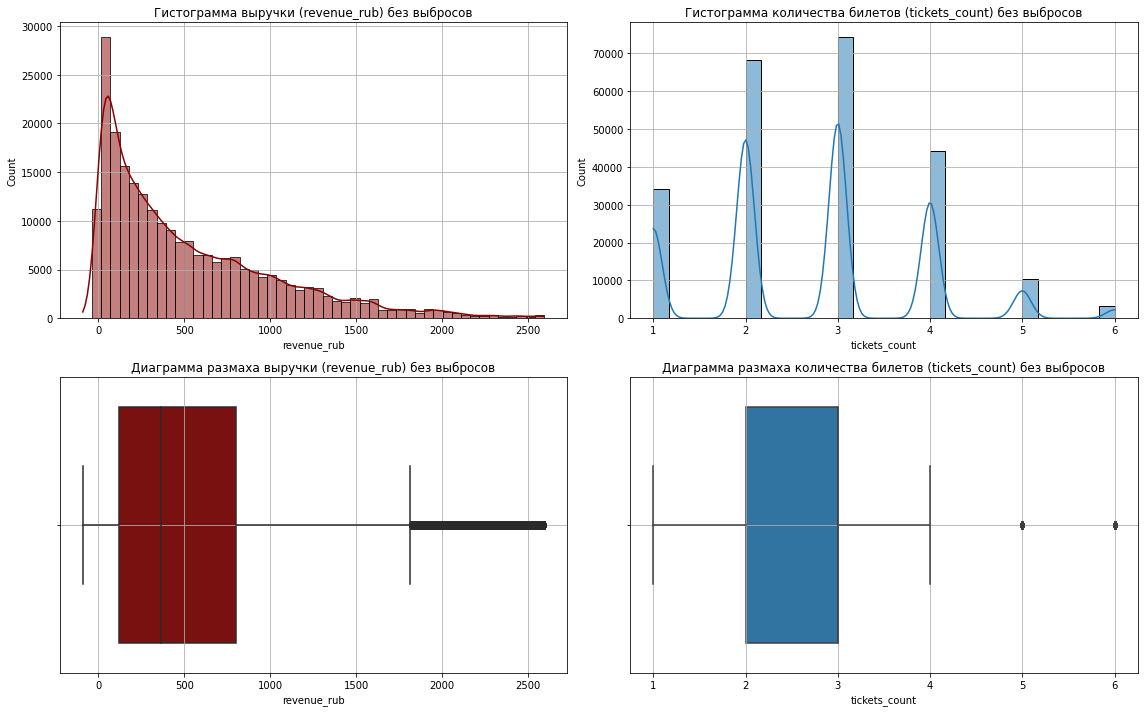

In [227]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `revenue_rub` без выбросов
sns.histplot(filtered_df['revenue_rub'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма выручки (revenue_rub) без выбросов')
axes[0, 0].grid()

# Диаграмма размаха для `revenue_rub` без выбросов
sns.boxplot(data = filtered_df, x = 'revenue_rub', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха выручки (revenue_rub) без выбросов')
axes[1, 0].grid()

# Гистограмма для `tickets_count` без выбросов
sns.histplot(filtered_df['tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма количества билетов (tickets_count) без выбросов')
axes[0, 1].grid()

# Диаграмма размаха для `tickets_count` без выбросов
sns.boxplot(data = filtered_df, x = 'tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха количества билетов (tickets_count) без выбросов')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

* Проверим столбец `revenue` на наличие аномалий.

In [228]:
# Проверим, имеет ли столбец `revenue` отрицательные значения
negative_count = (filtered_df['revenue'] < 0).sum()
print(f'Количество отрицательных значений: {negative_count}')

Количество отрицательных значений: 325


После удаления выбросов в столбце `revenue` видно, что выручка имеет большой разброс. Это может быть связано со спросом и популярностью различных мероприятий. Также, в данном столбце имеются отрицательные значения (количество: 325). Можно предложить гипотезу, что отрицательные значения - это возврат средств.

В столбце `tickets_count` видно, что в среднем, пользователи преобретают 2-3 билета на различные мероприятия. Минимальное количество пользователей платформы Яндекс Афиша преобретают 5-6 билетов.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Численные признаки изучены, удалены выбросы. Молодец, что обратила внимание на отрицательные значения выручки - вероятно, это возвраты, да.

**Промежуточный вывод**

Для оптимизации работы с данными в датафрейме была выполнена предобработка данных:

* Данные о выручке сервиса были приведены к единой валюте — российскому рублю. Добавлен столбец `revenue_rub`;
* Пропуски имеются только в столбце `days_since_prev` (7,6%). В данном столбце это означает, что пользователь совершил только одну покупку;
* Данные проверены на наличие явных и неявных дубликатов. Явные дубликаты отсутствуют. Обнаружены не явные дубликаты по лючевым столбцам (18.33% от общего числа данных) и удалены. Датафрейм после удаления неявных дубликатов содержит 237334 строк;
* Столбцы `revenue` и `tickets_count` были проверены на наличие выбросов. Данные выше 99-го перцентиля были удалены.

Финальный датафрейм содержит 234814 строк из 290611 исходных.

После удаления выбросов в столбце `revenue` данные имеют большой разброс и неравномерное распределение. Можно предложить гипотезу, что это может быть связано со спросом и популярностью различных мероприятий. Для выявления причины такого разброса необходимо проанализировать пользователей платформы и их предпочтения. Также, в данном столбце имеются отрицательные значения (количество: 325). Можно предложить гипотезу, что отрицательные значения - это возврат средств.

В столбце `tickets_count`, после удаления, выбросов данные имеют относительно нормальное распределение и небольшой разброс. В среднем, пользователи преобретают 2-3 билета на различные мероприятия. Это достаточно низкие показатели. Минимальное количество пользователей платформы Яндекс Афиша преобретают 5-6 билетов.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Молодец, что не забываешь про промежуточные выводы.

---

## 3. Создание профиля пользователя <a class="anchor" id="chapter3"></a>

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас необходимо построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Построим профиль пользователя — для каждого пользователя найдём:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавим два бинарных признака:

- `is_two` — совершил ли пользователь больше двух заказов;
- `is_five` — совершил ли пользователь больше пяти заказов.


* Перед тем как строить профиль, отсортируем данные по пользователю и времени совершения заказа.

In [229]:
# Отсортируем данные по времени совершения заказа
filtered_df = filtered_df.sort_values(by = ['user_id', 'order_ts'], ascending = True)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Сортировку нужно выполнить не только по дате, но и по пользователю - два признака в сортировке.
    

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Выполнена сортировка по пользователю и времени совершения заказа
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [230]:
# Выведем датафрейм
display(filtered_df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск,1448.36
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск,965.57
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,Прачечная,театр,Каменевский регион,Глиногорск,178.95
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,Билеты без проблем,стендап,Широковская область,Ягодиновка,661.53


* Создадим профиль пользователя

In [231]:
user_profile = filtered_df.groupby(['user_id']).agg(
    min_order_dt = ('order_dt', 'min'),  # дата первого заказа
    max_order_dt = ('order_dt', 'max'),  # дата последнего заказа
    device_type_canonical = ('device_type_canonical', 'first'),  # устройство, с которого был сделан первый заказ
    region_name = ('region_name', 'first'),  # регион, в котором был сделан первый заказ
    service_name = ('service_name', 'first'),  # билетного партнёра, к которому обращались при первом заказе
    event_type_main = ('event_type_main', 'first'),  # жанр первого посещённого мероприятия
    total_orders = ('order_id', 'count'),  # общее количество заказов
    avg_revenue_rub = ('revenue_rub', 'mean'),  # средняя выручка с одного заказа в рублях
    avg_tickets_count = ('tickets_count', 'mean')  # среднее количество билетов в заказе
)


# Рассчитываем среднее время между заказами для каждого пользователя
user_profile['average_time_between_orders'] = filtered_df.groupby('user_id')['days_since_prev'].mean().round(2)

# Заполним значениями-индексами пропуски в столбце `average_time_between_orders`
user_profile = user_profile.fillna({'average_time_between_orders':0})

# Создаем бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int) # пользователь совершил 2 и более заказа
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int) # пользователь совершил 5 и более заказов

# Оптимизируем целочисленный тип данных в полученных столбцах
user_profile['is_two'] = pd.to_numeric(user_profile['is_two'], downcast='integer')
user_profile['is_five'] = pd.to_numeric(user_profile['is_five'], downcast='integer')

# Преобразуем индекс user_id в обычный столбец
user_profile = user_profile.reset_index()

# Выведем новый датасет
display(user_profile)

,user_id,min_order_dt,max_order_dt,device_type_canonical,region_name,service_name,event_type_main,total_orders,avg_revenue_rub,avg_tickets_count,average_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,0.00,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.00,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.00,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,0.00,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21825,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,7,621.661429,2.714286,10.33,1,1
21826,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,850.995000,2.500000,74.00,1,0
21827,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,25,589.893600,2.680000,3.54,1,1
21828,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.530000,2.000000,0.00,0,0


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Собран потрет пользвоателя. Отлично, что используешь `agg` и словарь метрик.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Вместо `lambda x: x.iloc[0]` можно использовать агрегацию `first`.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Для оценки `average_time_between_orders` стоит усреднить значение признака `days_since_prev`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Вместо `lambda x: x.iloc[0]` использована агрегация `first`;
    
Для оценки `average_time_between_orders` усреднено значение признака `days_since_prev`.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Новые признаки можно делать сразу на базе `user_profile`.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

Всего в датафрейме 21830 уникальных пользователя.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших более 2 и более 5 заказов.

Также изучим статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оценим данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [232]:
# Общее число пользователей в выборке
nunique_users = user_profile['user_id'].nunique()

# Средняя выручка с одного заказа
average_revenue_per_order = round(user_profile['avg_revenue_rub'].mean(), 2)

# Доля пользователей, совершивших более 2 заказов
share_more_than_two = round(user_profile['is_two'].mean() * 100, 2)

# Доля пользователей, совершивших более 5 заказов
share_more_than_five = round(user_profile['is_five'].mean() * 100, 2)

# общее число заказов
count_orders = user_profile['total_orders'].nunique()

# Среднее число билетов в заказе
average_tickets_per_order = round(user_profile['avg_tickets_count'].mean(), 2)

# Среднее количество дней между покупками
overall_average_days = round(user_profile['average_time_between_orders'].mean(), 2)

print(f'Общее число пользователей: {nunique_users}')
print(f'Средняя выручка с одного заказа: {average_revenue_per_order}')
print(f'Доля пользователей, совершивших более 2 заказов: {share_more_than_two}%')
print(f'Доля пользователей, совершивших более 5 заказов: {share_more_than_five}%')
print(f'Среднее общее заказов: {count_orders}')
print(f'Среднее число билетов в заказе: {average_tickets_per_order}')
print(f'Среднее количество дней между покупками: {overall_average_days}')

Общее число пользователей: 21830
Средняя выручка с одного заказа: 541.83
Доля пользователей, совершивших более 2 заказов: 59.21%
Доля пользователей, совершивших более 5 заказов: 24.86%
Среднее общее заказов: 296
Среднее число билетов в заказе: 2.74
Среднее количество дней между покупками: 9.59


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут код прерывается с ошибкой ссылки на несуществующую переменную. Перед отправкой проекта (особенно в случае работы локально или в другом окружении) стоит проверять работоспособность кода __на платформе__ — это можно сделать, нажав на панели Jupiter Hub ``Kernel`` и ``Restart & Run All`` (см скриншот ниже).

![](https://i.postimg.cc/yd19rYf6/Screenshot-428.png)
        
Важно также убедиться, что все ячейки проекта исполнились - можно просто пролистать работу до конца и убедиться, что последняя ячейка исполнена. Такая проверка поможет тебе убедиться, что твоё решение будет должным образом воспроизведено во время ревью или во время передачи его заказчику - это очень важный этап, пренебрегать которым не стоит.
    
Остальную часть проекта смогу проверить после исправления ошибки кода.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправлено
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Для `average_tickets_per_order` и `overall_average_days` не нужна повторная группировка по `user_id` - данные профиля уже агрегированы на уровне пользователя.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

Проверим распределение и наличие выбросов в столбцах `total_orders` и `avg_tickets_count`.

In [233]:
# Выведем метрики для столбцов `total_orders`
print('Статистические показатели для столбца total_orders:')
user_profile['total_orders'].describe()

Статистические показатели для столбца total_orders:


count    21830.000000
mean        10.756482
std        100.348992
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       8569.000000
Name: total_orders, dtype: float64

По результатам анализа данных столбца `total_orders` было выявлено:

* присутствует большая разница между медианой (2) и средним значением (10,75), что говорит о неравномерном распределении данных;
* большой размах данных и высокое стандартное отклонение (100,34) говорят о большом разбросе данных;
* большое максимальное значение max (8569) указывает на наличие выбросов.

In [234]:
# Выведем метрики для столбцов `avg_tickets_count`
print('Статистические показатели для столбца avg_tickets_count:')
user_profile['avg_tickets_count'].describe()

Статистические показатели для столбца avg_tickets_count:


count    21830.000000
mean         2.737965
std          0.896790
min          1.000000
25%          2.000000
50%          2.750000
75%          3.000000
max          6.000000
Name: avg_tickets_count, dtype: float64

По результатам анализа данных столбца `avg_tickets_count` было выявлено:

* почти одинаковые значения медианы (2,75) и среднего значения (2,73), что говорит о нормальном распределении данных;
* небольшой размах данных и небольшое максимальное значение max(6) указывают на наличие правого хвоста.

Построим визуализации распределения значений для столбцов `total_orders` и `avg_tickets_count`.

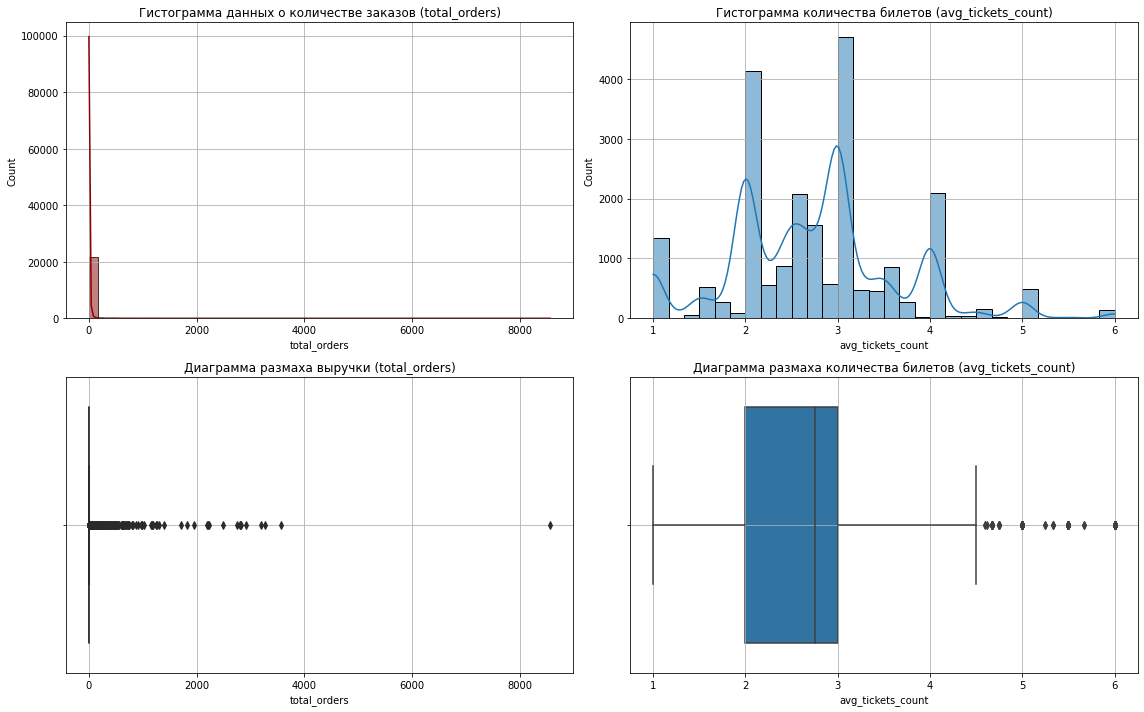

In [235]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `total_orders`
sns.histplot(user_profile['total_orders'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма данных о количестве заказов (total_orders)')
axes[0, 0].grid()

# Диаграмма размаха для `total_orders`
sns.boxplot(data = user_profile, x = 'total_orders', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха выручки (total_orders)')
axes[1, 0].grid()

# Гистограмма для `avg_tickets_count`
sns.histplot(user_profile['avg_tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма количества билетов (avg_tickets_count)')
axes[0, 1].grid()

# Диаграмма размаха для `avg_tickets_count`
sns.boxplot(data = user_profile, x = 'avg_tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха количества билетов (avg_tickets_count)')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

Из визуализации распределения значений столбца `total_orders` видно, что есть аномальное высокое значение (выше 8000). Пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны, что говорит о выбросах. Отсекаем значения выше 95-го перцентиля.

Из визуализации распределения значений столбца `avg_tickets_count` видно, что есть малое количество пользователей, которые купили билеты больше 5 штук. Данные распределены почти равномерно. Пик распределения смещен в левую сторону. Выбросы принимают минимальное значение, ими можно принебречь.

In [236]:
# Пороговые значения по 95 перцентилю
total_orders_threshold = user_profile['total_orders'].quantile(0.95)

print('Пороговые значения:')
print(f'- среднее количество заказов: {total_orders_threshold:.2f}')

Пороговые значения:
- среднее количество заказов: 25.00


In [237]:
# Фильтруем выбросы по количеству заказов
filtered_user_profile = user_profile[user_profile['total_orders'] <= total_orders_threshold]

In [238]:
# Проверяем размеры
print(f'Исходное количество записей: {len(user_profile)}')
print(f'Очищенное количество записей: {len(filtered_user_profile)}')
print(f'Процент удаленных записей: {1 - len(filtered_user_profile)/len(user_profile):.2%}')

Исходное количество записей: 21830
Очищенное количество записей: 20764
Процент удаленных записей: 4.88%


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> По числу заказов аномалии фильтровать не нужно: 6 заказов - неаномальное значение, а вполне себе корректное, к тому же это удалением приводит к появлению `nan` далее в анализе числа билетов.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Алексей, фильтровать по количеству заказов нужно, т.к. присутствуют выбросы с большими значениями (больше 8000). Скорее всего ты имел в виду данные из столбца `avg_tickets_count`. Учла это в вычислениях выше.
</div>

In [239]:
# Выведем метрики для столбца `total_orders` после удаления выбросов
print('Статистические показатели для столбца total_orders:')
filtered_user_profile['total_orders'].describe()

Статистические показатели для столбца total_orders:


count    20764.000000
mean         3.422895
std          4.090294
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         25.000000
Name: total_orders, dtype: float64

Построим визуализации распределения значений для столбцов `total_orders` и `avg_tickets_count` после очистки от выбросов.

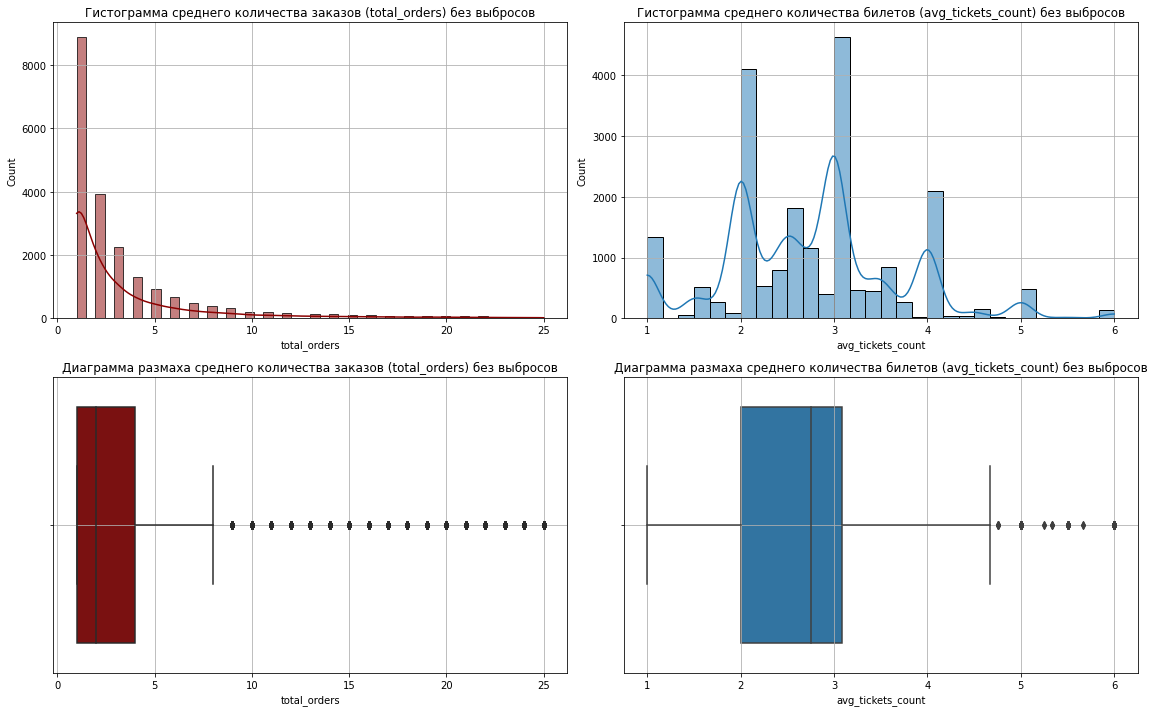

In [240]:
# Гистограммы и диаграммы размаха
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# Гистограмма для `total_orders` без выбросов
sns.histplot(filtered_user_profile['total_orders'], bins = 50, kde = True, ax = axes[0, 0], color = 'darkred')
axes[0, 0].set_title('Гистограмма среднего количества заказов (total_orders) без выбросов')
axes[0, 0].grid()

# Диаграмма размаха для `total_orders` без выбросов
sns.boxplot(data = filtered_user_profile, x = 'total_orders', ax = axes[1, 0], color = 'darkred')
axes[1, 0].set_title('Диаграмма размаха среднего количества заказов (total_orders) без выбросов')
axes[1, 0].grid()

# Гистограмма для `avg_tickets_count` без выбросов
sns.histplot(filtered_user_profile['avg_tickets_count'], bins = 30, kde = True, ax = axes[0, 1])
axes[0, 1].set_title('Гистограмма среднего количества билетов (avg_tickets_count) без выбросов')
axes[0, 1].grid()

# Диаграмма размаха для `avg_tickets_count` без выбросов
sns.boxplot(data = filtered_user_profile, x = 'avg_tickets_count', ax = axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха среднего количества билетов (avg_tickets_count) без выбросов')
axes[1, 1].grid()

plt.tight_layout()
plt.show()

После удаления выбросов в столбце `total_orders` видно, что среднее количество заказов имеет большой разброс. Большинство пользователей сделали меньше 5 заказов.  Пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны. 
Присутствует небольшая разница между медианой (2) и средним значением (3,42), что говорит о неравномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 8000) сделали в среднем по одному заказу.
Большое максимальное значение max (25) указывает на большой разброс в данных.

В столбце `avg_tickets_count` видно, что в среднем, пользователи преобретают 4 билета на различные мероприятия. Данные имеют равномерное распределение.
Присутствует небольшая разница между медианой (2,75) и средним значением (2,74), что говорит о равномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 4000) преобретали по 4 билета.

In [241]:
# Выведем отфильтрованный датасет
display(filtered_user_profile)

,user_id,min_order_dt,max_order_dt,device_type_canonical,region_name,service_name,event_type_main,total_orders,avg_revenue_rub,avg_tickets_count,average_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,0.00,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.00,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.00,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,0.00,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21825,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,7,621.661429,2.714286,10.33,1,1
21826,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,850.995000,2.500000,74.00,1,0
21827,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,25,589.893600,2.680000,3.54,1,1
21828,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.530000,2.000000,0.00,0,0


* Выведем статистические показатели по обновлённому датасету

In [242]:
# Общее число пользователей в выборке
nunique_users = filtered_user_profile['user_id'].nunique()

# Средняя выручка с одного заказа
average_revenue_per_order = round(filtered_user_profile['avg_revenue_rub'].mean(), 2)

# Доля пользователей, совершивших более 2 заказов
share_more_than_two = round(filtered_user_profile['is_two'].mean() * 100, 2)

# Доля пользователей, совершивших более 5 заказов
share_more_than_five = round(filtered_user_profile['is_five'].mean() * 100, 2)

# общее число заказов
count_orders = filtered_user_profile['total_orders'].nunique()

# Среднее число билетов в заказе
average_tickets_per_order = round(filtered_user_profile['avg_tickets_count'].mean(), 2)

# Среднее количество дней между покупками
overall_average_days = round(filtered_user_profile['average_time_between_orders'].mean(), 2)

print(f'Общее число пользователей: {nunique_users}')
print(f'Средняя выручка с одного заказа: {average_revenue_per_order}')
print(f'Доля пользователей, совершивших более 2 заказов: {share_more_than_two}%')
print(f'Доля пользователей, совершивших более 5 заказов: {share_more_than_five}%')
print(f'Среднее общее число заказов: {count_orders}')
print(f'Среднее число билетов в заказе: {average_tickets_per_order}')
print(f'Среднее количество дней между покупками: {overall_average_days}')

Общее число пользователей: 20764
Средняя выручка с одного заказа: 542.98
Доля пользователей, совершивших более 2 заказов: 57.11%
Доля пользователей, совершивших более 5 заказов: 21.0%
Среднее общее число заказов: 25
Среднее число билетов в заказе: 2.74
Среднее количество дней между покупками: 9.96


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут тоже нужно обновить агрегации по последним двум метрикам.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

**Промежуточный вывод**

Для создания профиля пользователя был отфильтрован исходный датафрейм по следующим параметрам: 

* общее число пользователей в выборке;
* средняя выручка с одного заказа;
* доля пользователей, совершивших более 2 и более 5 заказов.

Также были изучены статистические показатели:

* общее числуо заказов;
* среднее число билетов в заказе;
* среднее количество дней между покупками.

В ходе анализа было выявлено, что в столбцах `total_orders` имеются аномальные значения (выбросы). Данные выше 95-го перцентиля были удалены. В столбце `avg_tickets_count` присутствуют незначительный выброс. Им можно пренебречь.

Финальный датафрейм содержит 20764 строк из 21830 исходных. Процент удаленных записей: 4,88%.

После удаления выбросов в столбце `total_orders` видно, что среднее количество заказов имеет большой разброс. Большинство пользователей сделали меньше 5 заказов.  Пик распределения смещен в левую сторону. Также, присутствует длинный "хвост" с правой стороны. 
Присутствует небольшая разницамежду медианой (2) и средним значением (3,42), что говорит о неравномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 8000) сделали в среднем по одному заказу.
Большое максимальное значение max (25) указывает на большой разброс в данных.

В столбце `avg_tickets_count` видно, что в среднем, пользователи преобретают 4 билета на различные мероприятия. Данные имеют равномерное распределение.
Присутствует небольшая разница между медианой (2,75) и средним значением (2,74), что говорит о равномерном распределении данных. На гистограмме это показано: большинство пользователей (больше 4000) преобретали по 4 билета.

После удаления аномальных значений, был проведен повторный анализ статистических показателей по обновлённому датасету: 

Общее число пользователей: 20764

Средняя выручка с одного заказа: 542,98

Доля пользователей, совершивших более 2 заказов: 57,11%

Доля пользователей, совершивших более 5 заказов: 21,0%

Среднее общее число заказов: 25

Среднее число билетов в заказе: 2,74

Среднее количество дней между покупками: 9,96

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Аномалии в данных изучены и отфильтрованы.

---

## 4. Исследовательский анализ данных<a class="anchor" id="chapter4"></a>

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучим распределение пользователей по признакам.

- Сгруппируем пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
    
    
- Подсчитаем общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.

* Исследуем распределения пользователей по первому типу мероприятия.

In [243]:
# Выведем количество пользователей по типу первого мероприятия
count_event_type = filtered_user_profile['event_type_main'].value_counts()

# Выведем долю пользователей по типу первого мероприятия
share_event_type = round(count_event_type / len(filtered_user_profile['user_id']) * 100, 2)

print(f'Количество пользователей по типу первого мероприятия:')
display(count_event_type)
print(f'Доля пользователей по типу первого мероприятия:')
display(share_event_type.apply(lambda x: f'{x}%'))

Количество пользователей по типу первого мероприятия:


концерты    9166
другое      5173
театр       4073
стендап     1075
спорт        778
выставки     405
ёлки          94
Name: event_type_main, dtype: int64

Доля пользователей по типу первого мероприятия:


концерты    44.14%
другое      24.91%
театр       19.62%
стендап      5.18%
спорт        3.75%
выставки     1.95%
ёлки         0.45%
Name: event_type_main, dtype: object

Наибольшее количество пользователей совершили первый заказ на концерт (9166 пользователя, 44,14%).

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Доли удобнее считать с помощью `value_counts(normalize=True)`.

Построим график распределения пользователей по первому типу мероприятия.

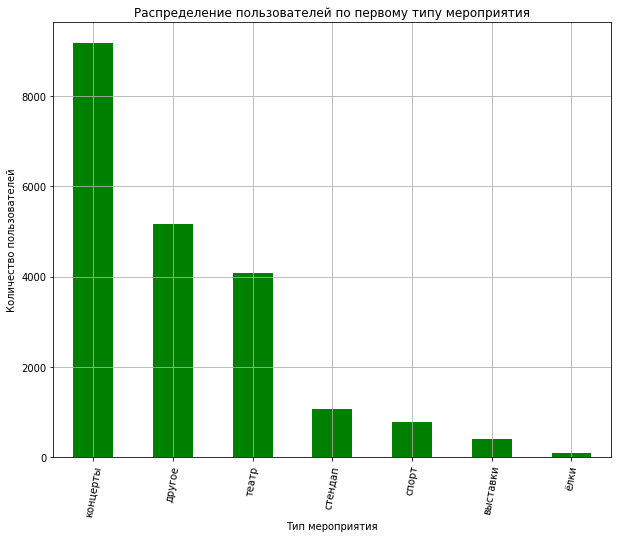

In [244]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_event_type.plot(kind = 'bar',
                      grid = True,
                      legend = False,
                      color = 'green',
                      rot = 80
)

plt.title('Распределение пользователей по первому типу мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
plt.show()

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Технические комментарии типа `<AxesSubplot:xlabel='datetime'>` стоит убирать - это можно сделать, поставив точку с запятой в последней строке кода в блоке визуализации, либо сделать последней строкой кода этого блока метод `plt.show()`.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

По результатам анализа видно, что самый популярный тип мероприятия - концерты, самые не популярные - выставки и ёлки.

* Исследуем распределения пользователей по типу устройства, с которого совершена первая покупка.

In [245]:
# Выведем количество пользователей по типу устройства, с которого совершена первая покупка
count_device_type = filtered_user_profile['device_type_canonical'].value_counts()

# Выведем долю пользователей по типу устройства, с которого совершена первая покупка
share_device_type = round(count_device_type / len(filtered_user_profile['user_id']) * 100, 2)

print(f'Количество пользователей по типу устройства, с которого совершена первая покупка:')
display(count_device_type)
print(f'Доля пользователей по типу устройства, с которого совершена первая покупка:')
display(share_device_type.apply(lambda x: f'{x}%'))

Количество пользователей по типу устройства, с которого совершена первая покупка:


mobile     17222
desktop     3542
Name: device_type_canonical, dtype: int64

Доля пользователей по типу устройства, с которого совершена первая покупка:


mobile     82.94%
desktop    17.06%
Name: device_type_canonical, dtype: object

Построим график распределения пользователей по типу устройства, с которого совершена первая покупка.

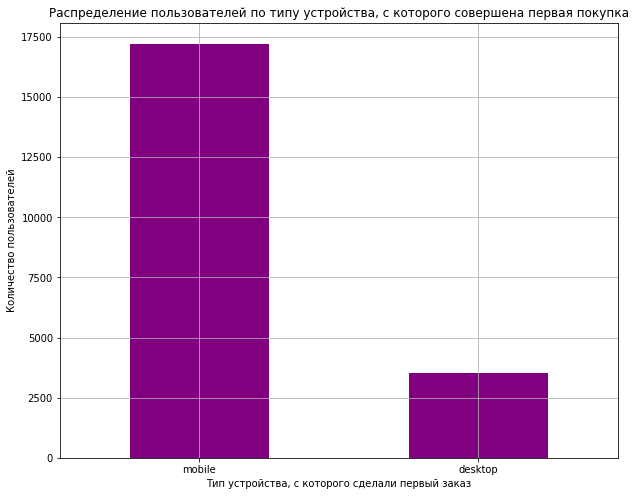

In [246]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_device_type.plot(kind = 'bar',
                       grid = True,
                       legend = False,                                        
                       color = 'purple',
                       rot = 0
)

plt.title('Распределение пользователей по типу устройства, с которого совершена первая покупка')
plt.xlabel('Тип устройства, с которого сделали первый заказ')
plt.ylabel('Количество пользователей')
plt.show()

Наибольшее количество пользователей совершили первый заказ с помощью мобильного устройства (17222 пользователей, 82,94%).

* Исследуем распределения пользователей по региону проведения мероприятия из первого заказа.

In [247]:
# Выведем количество пользователей по региону проведения мероприятия из первого заказа
count_region = filtered_user_profile['region_name'].value_counts()

# Выведем долю пользователей по региону проведения мероприятия из первого заказа
share_region = round(count_region / len(filtered_user_profile['user_id']) * 100, 2)

# Выведем ТОП-10 регионов регионов по количеству пользователей
print(f'Количество пользователей по региону проведения мероприятия из первого заказа:')
display(count_region.head(10))
print(f'Доля пользователей по региону проведения мероприятия из первого заказа:')
display(share_region.apply(lambda x: f'{x}%').head(10))

Количество пользователей по региону проведения мероприятия из первого заказа:


Каменевский регион      6783
Североярская область    3603
Широковская область     1190
Озернинский край         662
Малиновоярский округ     516
Травяная область         469
Шанырский регион         463
Светополянский округ     436
Речиновская область      421
Яблоневская область      400
Name: region_name, dtype: int64

Доля пользователей по региону проведения мероприятия из первого заказа:


Каменевский регион      32.67%
Североярская область    17.35%
Широковская область      5.73%
Озернинский край         3.19%
Малиновоярский округ     2.49%
Травяная область         2.26%
Шанырский регион         2.23%
Светополянский округ      2.1%
Речиновская область      2.03%
Яблоневская область      1.93%
Name: region_name, dtype: object

Наибольшее количество пользователей совершили первый заказ в Каменевском регионе (6783 пользователей, 32,67%).

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут стоит вывести ТОП-10 регионов - в текущем виде не очень репрезентативно.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

Построим график распределения пользователей по региону проведения мероприятия из первого заказа. Выберем топ-10 регионов, из которых пользователе чаще делают заказы.

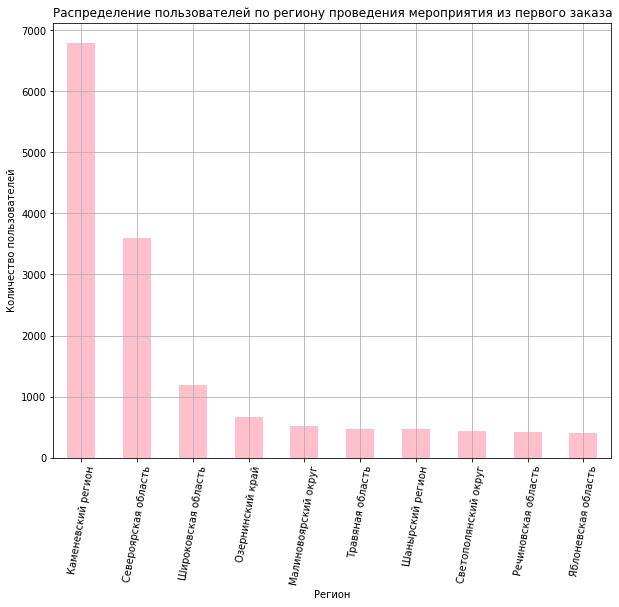

In [248]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_region.head(10).plot(kind = 'bar',
                           grid = True,
                           legend = False,                                        
                           color = 'pink',
                           rot = 80
)

plt.title('Распределение пользователей по региону проведения мероприятия из первого заказа')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.show()

Самые популярные регионы: Каменевский регион (6498 пользователей), Североярская область (3410 пользователей), Широковская область (1114 пользователей). 

Самые непопулярные регионы: Верхозёрский край, Сосноводолинская область, Светолесский край,  Яснопольский округ. В этих регионах по 1 пользователю.

* Исследуем распределения пользователей по билетному оператору, продавшему билеты на первый заказ.

In [249]:
# Выведем количество пользователей по билетному оператору, продавшему билеты на первый заказ
count_service = filtered_user_profile['service_name'].value_counts()

# Выведем долю пользователей по билетному оператору, продавшему билеты на первый заказ
share_service = round(count_service / len(filtered_user_profile['user_id']) * 100, 2)

print(f'Количество пользователей по билетному оператору, продавшему билеты на первый заказ:')
display(count_service)
print(f'Доля пользователей по типу билетному оператору, продавшему билеты на первый заказ:')
display(share_service.apply(lambda x: f'{x}%'))

Количество пользователей по билетному оператору, продавшему билеты на первый заказ:


Билеты без проблем        4962
Мой билет                 2834
Лови билет!               2710
Билеты в руки             2441
Облачко                   2113
Весь в билетах            1231
Лучшие билеты             1134
Прачечная                  554
Край билетов               437
Дом культуры               339
Яблоко                     309
Тебе билет!                299
Городской дом культуры     207
Мир касс                   198
За билетом!                196
Быстробилет                159
Show_ticket                157
Выступления.ру              93
Восьмёрка                   82
Быстрый кассир              54
Crazy ticket!               44
Росбилет                    40
Радио ticket                36
Телебилет                   27
Реестр                      27
Цвет и билет                21
Шоу начинается!             18
КарандашРУ                  14
Кино билет                   9
Вперёд!                      7
Билет по телефону            6
Тех билет                    3
Лимоны  

Доля пользователей по типу билетному оператору, продавшему билеты на первый заказ:


Билеты без проблем         23.9%
Мой билет                 13.65%
Лови билет!               13.05%
Билеты в руки             11.76%
Облачко                   10.18%
Весь в билетах             5.93%
Лучшие билеты              5.46%
Прачечная                  2.67%
Край билетов                2.1%
Дом культуры               1.63%
Яблоко                     1.49%
Тебе билет!                1.44%
Городской дом культуры      1.0%
Мир касс                   0.95%
За билетом!                0.94%
Быстробилет                0.77%
Show_ticket                0.76%
Выступления.ру             0.45%
Восьмёрка                  0.39%
Быстрый кассир             0.26%
Crazy ticket!              0.21%
Росбилет                   0.19%
Радио ticket               0.17%
Телебилет                  0.13%
Реестр                     0.13%
Цвет и билет                0.1%
Шоу начинается!            0.09%
КарандашРУ                 0.07%
Кино билет                 0.04%
Вперёд!                    0.03%
Билет по т

Построим график распределения пользователей по билетному оператору, продавшему билеты на первый заказ.

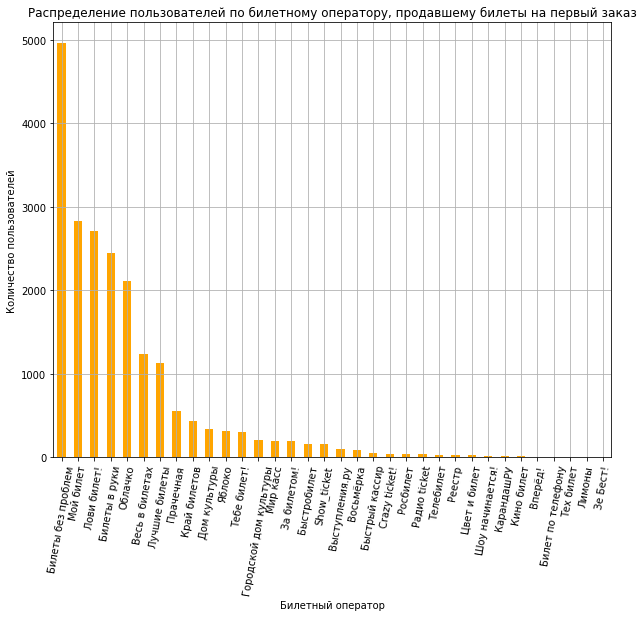

In [250]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

count_service.plot(kind = 'bar',
                   grid = True,
                   legend = False,                                        
                   color = 'orange',
                   rot = 80
)

plt.title('Распределение пользователей по билетному оператору, продавшему билеты на первый заказ')
plt.xlabel('Билетный оператор')
plt.ylabel('Количество пользователей')
plt.show()

Самые популярные билетные операторы: Билеты без проблем (4752 пользователей), Мой билет (2715 пользователей), Лови билет! (2586 пользователей), Билеты в руки (2332 пользователей), Облачко (2066 пользователей), Весь в билетах (1173 пользователей), Лучшие билеты (1070 пользователей).

Самые не популярные билетные операторы: Лимоны (2 пользователя), Тех билет (2 пользователя), Зе Бест! (1 пользователь).

**Промежуточный вывод**

В ходе исследования данных были выявлены следующие результаты: 

* **По типу первого мероприятия.** Самый популярный тип мероприятия - концерты (44,76 %), самые не популярные - выставки (1,98 %) и ёлки (0,44 %);
* **По типу устройства, с которого совершена первая покупка.** Мобильный телефон - самый популярный тип устройста (83,08 %), у компьютера - 16,92 %;
* **По региону проведения мероприятия из первого заказа.** Самые популярные регионы проведения мероприятий: 
    * Каменевский регион (32,73 %);
    * Североярская область (17,17 %);
    * Широковская область (5,6 %).

Самые непопулярные регионы: Верхозёрский край, Сосноводолинская область, Светолесский край, Яснопольский округ. В этих регионах по 0,01 %;
* **По билетному оператору, продавшему билеты на первый заказ.** Самые популярные билетные операторы: 
    * Билеты без проблем (23,93 %);
    * Мой билет (13,67 %);
    * Лови билет! (13,02 %);
    * Билеты в руки (11,74 %);
    * Облачко (10,40 %).
    
Самые не популярные билетные операторы: Лимоны, Тех билет, Зе Бест! - по 0,01 %.

Анализ распределения пользователей по сегментам показал, что распределение неравномерное - существует несколько ярко выраженных "точек входа":

* основной тип первого мероприятия - **концерты**;
* основное устройство для совершения первого заказа - **мобильное**;
* региональная концентрация первых заказов - **Каменевский регион**;
* лидер среди билетных операторов при совершении первого заказа - **"Билеты без проблем"**.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выводы о самом популярном ("концерты") и самых непопулярных ("выставки", "ёлки") типах мероприятий, включая их процентные доли, указаны верно.

Данные о долях мобильных телефонов и компьютеров в первой покупке точно соответствуют таблице.

Перечисление и процентные доли как самых популярных (Каменевский, Североярская, Широковская области), так и самых непопулярных регионов (с долей 0,01 %) полностью корректны.

Список лидеров (Топ-5) и аутсайдеров, а также их процентные доли, в точности отражают данные из таблиц и графика.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Нужно явно прокомментировать точки входа.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

---

**Задача 4.1.2.** Проанализируем возвраты пользователей:

- Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа.

In [251]:
# Группируем пользователей по типу первого мероприятия
grouped_event_type = (filtered_user_profile.groupby('event_type_main').agg(users_count=('user_id', 'nunique'), 
                                                                         share_return_users=('is_two', 'mean')).reset_index())

# Сортируем для наглядности
grouped_event_type = grouped_event_type.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
grouped_event_type['share_return_users'] = grouped_event_type['share_return_users'].round(2)

print('Доля пользователей, совершивших два и более заказа, по типу первого мероприятия:')
display(grouped_event_type)

Доля пользователей, совершивших два и более заказа, по типу первого мероприятия:


,event_type_main,users_count,share_return_users
0,выставки,405,0.61
5,театр,4073,0.59
2,концерты,9166,0.57
4,стендап,1075,0.57
1,другое,5173,0.55
6,ёлки,94,0.55
3,спорт,778,0.52


* Визуализируем полученный результат.

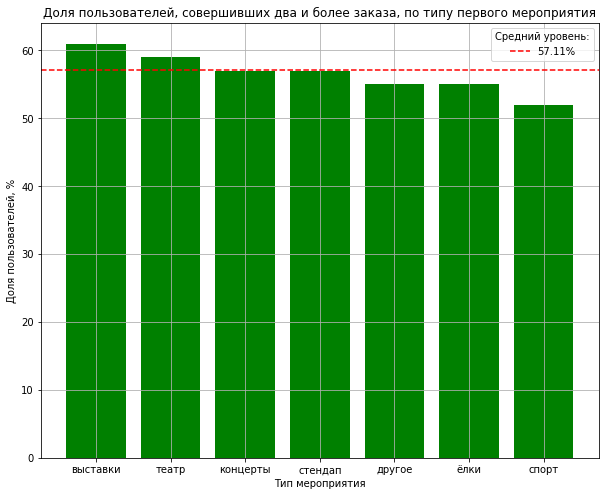

In [252]:
plt.figure(figsize=(10, 8))
mean_is_two = round(filtered_user_profile['is_two'].mean() * 100, 2)

plt.bar(grouped_event_type['event_type_main'], grouped_event_type['share_return_users'] * 100, color='green')

plt.axhline(mean_is_two, color='r', linestyle='--')

plt.title('Доля пользователей, совершивших два и более заказа, по типу первого мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля пользователей, %')
plt.grid(True)
plt.legend(title='Средний уровень:', labels=[f'{mean_is_two}%'])
plt.show()


Распределение доли пользователей, совершивших два и более заказа по типу первого мероприятия равномерное. Наибольшее количество возвращающихся пользователей в типах: выставки (61%), театр (59%), концерты (57%).

In [253]:
# Группируем пользователей, совершивших два и более заказа, по типу устройства, с которого совершена первая покупка, и считаем их долю
group_device_type = (filtered_user_profile.groupby('device_type_canonical').agg(users_count=('user_id', 'nunique'), 
                                                                  share_return_users=('is_two', 'mean')).reset_index())

# Сортируем для наглядности
group_device_type = group_device_type.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
group_device_type['share_return_users'] = group_device_type['share_return_users'].round(2)

print('Доля пользователей, совершивших два и более заказа, по типу устройства:')
display(group_device_type)

Доля пользователей, совершивших два и более заказа, по типу устройства:


,device_type_canonical,users_count,share_return_users
0,desktop,3542,0.60
1,mobile,17222,0.57


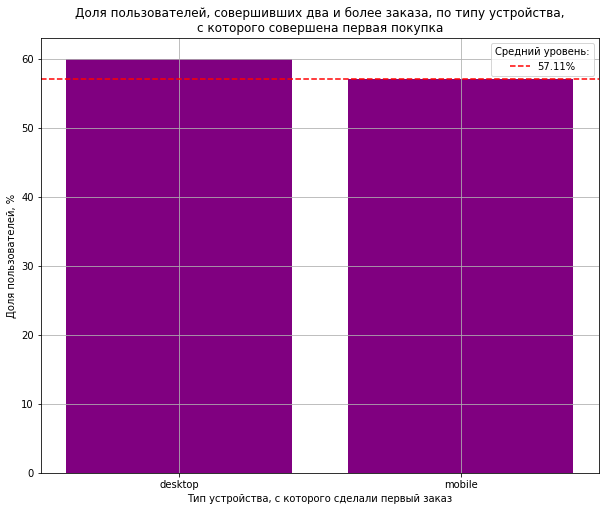

In [254]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

# Рассчитываем средний уровень по всей выборке
mean_is_two = round(filtered_user_profile['is_two'].mean() * 100, 2)

plt.bar(group_device_type['device_type_canonical'], group_device_type['share_return_users'] * 100, color='purple')

# Добавляем горизонтальную линию для среднего уровня
plt.axhline(mean_is_two, color='r', linestyle='--')

plt.title('Доля пользователей, совершивших два и более заказа, по типу устройства,\nс которого совершена первая покупка')
plt.xlabel('Тип устройства, с которого сделали первый заказ')
plt.ylabel('Доля пользователей, %')
plt.grid(True)
plt.legend(title = 'Средний уровень:', labels = [f'{mean_is_two}%'])
plt.show()

Распределение доли возвращающихся пользователей по типу устройства, с которого совершена первая покупка, равномерное. 

Количество пользователей, совершивших два и более заказа, для стационарных устройств (60%) немного больше, чем для мобильных (57%).

In [255]:
# Группируем пользователей, совершивших два и более заказа, по региону проведения мероприятия из первого заказа
group_region = (filtered_user_profile.groupby('region_name').agg(users_count=('user_id', 'nunique'), 
                                                             share_return_users=('is_two', 'mean')).reset_index())

# Отбираем топ-10 регионов по размеру сегмента, чтобы избежать нестабильных долей в маленьких группах
top10_regions = group_region.sort_values('users_count', ascending=False).head(10)

# Сортируем для наглядности
top10_regions = top10_regions.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
top10_regions['share_return_users'] = top10_regions['share_return_users'].round(2)

# Выведем ТОП-10 самых популярных регионов
print('Доля пользователей, совершивших два и более заказа, по региону проведения мероприятия из первого заказа:')
display(top10_regions)

Доля пользователей, совершивших два и более заказа, по региону проведения мероприятия из первого заказа:


,region_name,users_count,share_return_users
57,Светополянский округ,436,0.62
76,Шанырский регион,463,0.61
77,Широковская область,1190,0.61
60,Североярская область,3603,0.60
52,Речиновская область,421,0.59
23,Каменевский регион,6783,0.58
74,Травяная область,469,0.57
78,Яблоневская область,400,0.56
41,Малиновоярский округ,516,0.53
45,Озернинский край,662,0.50


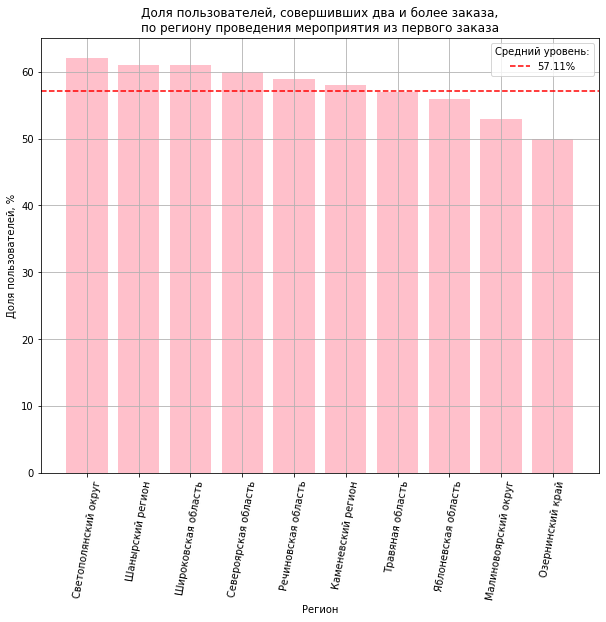

In [256]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

# Рассчитываем средний уровень по всей выборке
mean_is_two = round(filtered_user_profile['is_two'].mean() * 100, 2)

plt.bar(top10_regions['region_name'], top10_regions['share_return_users'] * 100, color='pink')

# Добавляем горизонтальную линию для среднего уровня
plt.axhline(mean_is_two, color='r', linestyle='--')

plt.title('Доля пользователей, совершивших два и более заказа,\nпо региону проведения мероприятия из первого заказа')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей, %')
plt.legend(title = 'Средний уровень:', labels = [f'{mean_is_two}%'])
plt.grid(True)
plt.xticks(rotation=80)
plt.show()

Распределение доли возвращающихся пользователей по региону проведения мероприятия из первого заказа равномерное. 

Наибольшее количество возвращающихся пользователей в Шанырском регионе (61%) и Светополянском округе (62%).

In [257]:
# Группируем пользователей, совершивших два и более заказа, по билетному оператору, продавшему билеты на первый заказ
group_service = (filtered_user_profile.groupby('service_name').agg(users_count=('user_id', 'nunique'), 
                                                               share_return_users=('is_two', 'mean')).reset_index())

# Отбираем топ-10 билетных операторов по размеру сегмента, чтобы избежать нестабильных долей в маленьких группах
top10_services = group_service.sort_values('users_count', ascending=False).head(10)

# Сортируем для наглядности
top10_services = top10_services.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
top10_services['share_return_users'] = top10_services['share_return_users'].round(2)

print('Доля пользователей, совершивших два и более заказа, по билетному оператору, продавшему билеты на первый заказ:')
display(top10_services)

Доля пользователей, совершивших два и более заказа, по билетному оператору, продавшему билеты на первый заказ:


,service_name,users_count,share_return_users
17,Край билетов,437,0.62
12,Дом культуры,339,0.59
4,Билеты в руки,2441,0.58
24,Прачечная,554,0.58
7,Весь в билетах,1231,0.58
23,Облачко,2113,0.57
19,Лови билет!,2710,0.57
22,Мой билет,2834,0.57
3,Билеты без проблем,4962,0.56
20,Лучшие билеты,1134,0.56


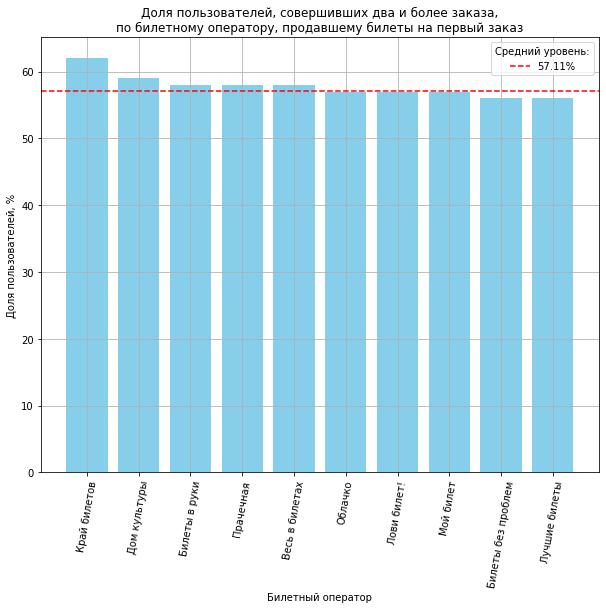

In [258]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

# Рассчитываем средний уровень по всей выборке
mean_is_two = round(filtered_user_profile['is_two'].mean() * 100, 2)

plt.bar(top10_services['service_name'], top10_services['share_return_users'] * 100, color='skyblue')

# Добавляем горизонтальную линию для среднего уровня
plt.axhline(mean_is_two, color='r', linestyle='--')

plt.title('Доля пользователей, совершивших два и более заказа,\nпо билетному оператору, продавшему билеты на первый заказ')
plt.xlabel('Билетный оператор')
plt.ylabel('Доля пользователей, %')
plt.legend(title = 'Средний уровень:', labels = [f'{mean_is_two}%'])
plt.grid(True)
plt.xticks(rotation=80)
plt.show()

Распределение доли возвращающихся пользователей по билетному оператору, продавшему билеты на первый заказ, равномерное. 

Наибольшее количество возвращающихся пользователей купили билеты у операторов "Край билетов" (62%) и "Дом культуры" (59%).

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Для сравнения со средним уровнем выборки можно использовать `axhline`.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

**Промежуточный вывод**

Анализ распределения возвращающихся пользователей по сегментам показал, что распределение равномерное, ярко выраженных "точек входа" нет, однако чаще совершают повторный заказ при следующих условиях:

* основной тип первого мероприятия - **выставки, театр, концерты**;
* основное устройство для совершения первого заказа - **стационарное**;
* регион проведения мероприятий первых заказов - **Шанырский регион** и **Светополянский округ**. При этом регионы с низкой плотностью населения (с десятками пользователей) не учитывались для избежания статистической нестабильности долей;
лидеры среди билетных операторов при совершении первого заказа - **"Край билетов"** и **"Дом культуры"**. При этом менее популярные операторы (с десятками пользователей) не учитывались для избежания статистической нестабильности долей.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> 
Нужно сделать вывод о точках входа, сравнив доли со средней долей по выборке.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

In [259]:
# Отбираем данные для типа первого мероприятия "спорт" и "концерты", чтобы сравнить долю возвращающихся пользователей
filtered_events = grouped_event_type[grouped_event_type['event_type_main'].isin(['спорт', 'концерты'])]

# Выводим результаты отфильтрованной группировки
print(filtered_events[['event_type_main', 'share_return_users']])

  event_type_main  share_return_users
2        концерты                0.57
3           спорт                0.52


**Гипотеза 1** не подтверждается: пользователи, впервые совершившие заказ на спортивные мероприятия, совершают повторный заказ реже (52%), чем пользователи, оформившие свой первый заказ на концерты (57%).

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут нужно актуализировать, так как доли посчитаны неверно.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

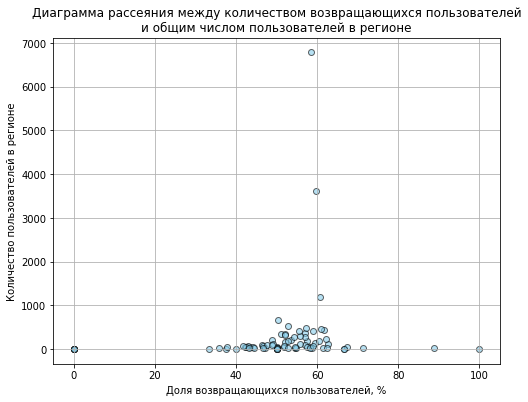

In [260]:
# Построим диаграмму рассеяния между долей возвращающихся пользователей 'share_return_users' и общим количеством пользователей 'users_count'
plt.figure(figsize=(8, 6))
plt.scatter(group_region['share_return_users'] * 100, 
            group_region['users_count'], 
            alpha=0.6, 
            color='skyblue', 
            edgecolors='black')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Количество пользователей в регионе')
plt.title('Диаграмма рассеяния между количеством возвращающихся пользователей\nи общим числом пользователей в регионе')
plt.grid(axis='both')
plt.show()

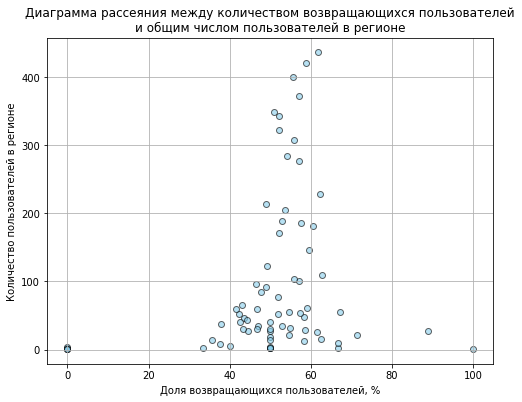

Корреляция между количеством возвращающихся пользователей и общим числом пользователей в регионе (без выбросов): 0.23


In [261]:
# Обрежем выбросы по столбцу 'users_count'
Q1 = group_region['users_count'].quantile(0.25)
Q3 = group_region['users_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_region = group_region[(group_region['users_count'] >= lower_bound) & (group_region['users_count'] <= upper_bound)]

# Перестроим диаграмму рассеяния
plt.figure(figsize=(8, 6))
plt.scatter(filtered_region['share_return_users'] * 100, 
            filtered_region['users_count'], 
            alpha=0.6, 
            color='skyblue', 
            edgecolors='black')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Количество пользователей в регионе')
plt.title('Диаграмма рассеяния между количеством возвращающихся пользователей\nи общим числом пользователей в регионе')
plt.grid(axis='both')
plt.show()

# Вычислим корреляцию без выбросов по столбцу 'users_count'
corr = filtered_region['share_return_users'].corr(filtered_region['users_count'])
print(f'Корреляция между количеством возвращающихся пользователей и общим числом пользователей в регионе (без выбросов): {corr:.2f}')

**Гипотеза 2** не подтверждается. По диаграмме рассеяния видно, что тип связи между количеством возвращающихся пользователей и общим числом пользователей в регионе - нелинейный, однозначно установить направление и силу связи затруднительно. При первичном построении диаграммы рассеяния был обнаружен аномальный выброс общего количества пользователей в регионе, впоследствии диаграмма перестроена без выбросов по столбцу `users_count`, пересчитано значение корреляции и получено значение 0,23, что соответствует слабой корреляционной связи.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Главный вывод о том, что частота посещений мероприятий не влияет на вероятность возврата пользователей, является верной интерпретацией графика.

На диаграмме видно, что высокая "Частота посещений" (синий столбец, например, "Каменевский регион") не гарантирует самую высокую "Долю повторных заказов" (оранжевый столбец).

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Утверждается, что доля покупки билетов примерно одинакова в топ-10 активных регионов.

Это не соответствует данным на графике. Оранжевые столбцы (доля повторных заказов) демонстрируют значительный разброс: от самого низкого значения около 30% (Озернинский край) до самого высокого значения около 45% (Шанырский регион). Такой диапазон в 15 процентных пунктов нельзя охарактеризовать как "примерно одинаковый".

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

- Построим сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
    
        
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

In [262]:
# Фильтрация пользователей, совершивших один заказ
one_order_users = filtered_user_profile.loc[filtered_user_profile['is_two'] == 0, 'avg_revenue_rub']

# Фильтрация вернувшихся пользователей, совершивших 2 и более заказа
multiple_orders_users = filtered_user_profile.loc[filtered_user_profile['is_two'] == 1, 'avg_revenue_rub']

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Бинарные признаки тут не подойдут - нужно явно делать фильтрации по числу заказов.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

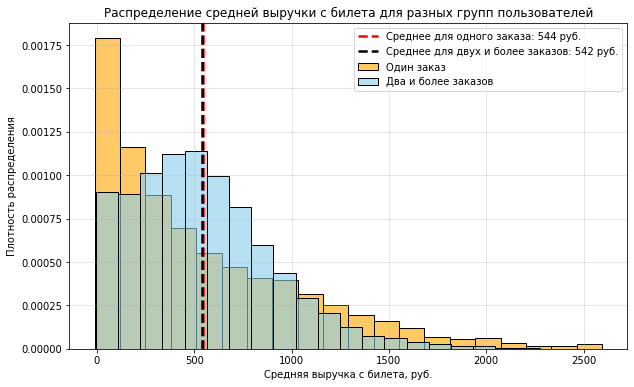

In [263]:
# Строим гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(one_order_users, color='orange', bins=20, label='Один заказ', kde=False, alpha=0.6, stat='density')
sns.histplot(multiple_orders_users, color='skyblue', bins=20, label='Два и более заказов', kde=False, alpha=0.6, stat='density')

# Добавляем вертикальные линии со средними значениями
plt.axvline(one_order_users.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Среднее для одного заказа: {one_order_users.mean():.0f} руб.')
plt.axvline(multiple_orders_users.mean(), color='black', linestyle='--', linewidth=2.5, label=f'Среднее для двух и более заказов: {multiple_orders_users.mean():.0f} руб.')

# Строим диаграмму распределения
plt.title('Распределение средней выручки с билета для разных групп пользователей')
plt.xlabel('Средняя выручка с билета, руб.')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

**Промежуточный вывод**

Основная концентрация пользователей обеих групп (и с одним заказом, и с несколькими) находится в диапазоне до 750 рублей средней выручки с билета. 

Формы распределений двух групп одинаковы — пик смещен в левую сторону, с постепенным спадом при увеличении суммы средней выручки с билета. Для распределения группы пользователей с одним заказом наблюдается высокая плотность распределения в диапазоне от 0 до 125 рублей.

Среднее значение средней выручки с билета отличается незначительно:

* у пользователей с одним заказом 544 руб.;
* у пользователей с несколькими заказами 542 руб.

Схожесть средних значений показывает, что зависимости между величиной средней выручки с билета и совершением повторных заказов нет.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Графики нужно наложить друг на друга - в этом ключевая идея сравнения.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

---

**Задача 4.2.2.** Сравним распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [264]:
# Фильтрация пользователей, совершивших 2–4 заказа
two_four_order_users = filtered_user_profile[(filtered_user_profile['total_orders'] >= 2) & (filtered_user_profile['total_orders'] < 5)]

# Фильтрация вернувшихся пользователей, совершившие 5 и более заказов
more_five_orders_users = filtered_user_profile[filtered_user_profile['is_five'] == True]

# Извлекаем среднюю выручку
two_four_revenue = two_four_order_users['avg_revenue_rub']
more_five_revenue = more_five_orders_users['avg_revenue_rub']

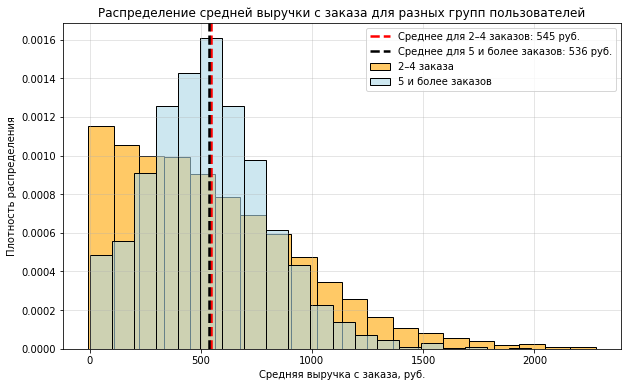

In [265]:
# Строим гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(two_four_revenue, color='orange', bins=20, label='2–4 заказа', kde=False, alpha=0.6, stat='density', edgecolor='black')
sns.histplot(more_five_revenue, color='lightblue', bins=20, label='5 и более заказов', kde=False, alpha=0.6, stat='density', edgecolor='black')

# Добавляем средние линии
plt.axvline(two_four_revenue.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Среднее для 2–4 заказов: {two_four_revenue.mean():.0f} руб.')
plt.axvline(more_five_revenue.mean(), color='black', linestyle='--', linewidth=2.5, label=f'Среднее для 5 и более заказов: {more_five_revenue.mean():.0f} руб.')

# Оформляем график
plt.title('Распределение средней выручки с заказа для разных групп пользователей')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

**Промежуточный вывод**

Основная концентрация пользователей обеих групп находится в диапазоне до 900 рублей средней выручки с заказа.

Форма распределения группы для 2-4 заказов - правосторонняя, с постепенным спадом при увеличении суммы средней выручки с заказа.

Форма распределения группы для 5 и более заказов - также правосторонняя, но с ростом плотности распределения до среднего значения суммы средней выручки с заказа и последующим постепенным спадом.

Среднее значение средней выручки с заказа отличается незначительно:

* у пользователей с 2-4 заказами 545 руб.;
* у пользователей с 5 и больше заказами 536 руб.

Схожесть средних значений показывает, что существенных различий по средней выручке с заказа между группами нет: частота заказов не связана напрямую с размером среднего чека.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> По этому заданию аналогичные замечания: использование числа билетов вместо бинарных признаков и наложение гистограмм для лучшего сравнения.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучим распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишем основные наблюдения;

- Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.

In [266]:
# Создаем сегменты по среднему количеству билетов в заказе
bins = [0, 2, 3, 5, float('inf')]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5 и более билетов']

tickets_segment_profile = filtered_user_profile[['user_id', 'avg_tickets_count', 'is_two']].copy()
tickets_segment_profile['tickets_segment'] = pd.cut(tickets_segment_profile['avg_tickets_count'], bins=bins, labels=labels, right=False)

# Группируем по сегментам и считаем долю пользователей, совершивших повторные заказы
segment_stats = (tickets_segment_profile.groupby('tickets_segment').agg(users_count=('user_id', 'nunique'), 
                                                                        share_return_users=('is_two', 'mean')).reset_index())

# Округляем долю возвращающихся пользователей до двух знаков
segment_stats['share_return_users'] = segment_stats['share_return_users'].round(2)

# Выводим результаты группировки
print(segment_stats)

     tickets_segment  users_count  share_return_users
0         1–2 билета         2280                0.44
1         2–3 билета         8800                0.70
2        3–5 билетов         9036                0.51
3  5 и более билетов          648                0.14


Визуализируем распределение пользователей по среднему количеству билетов в заказе.

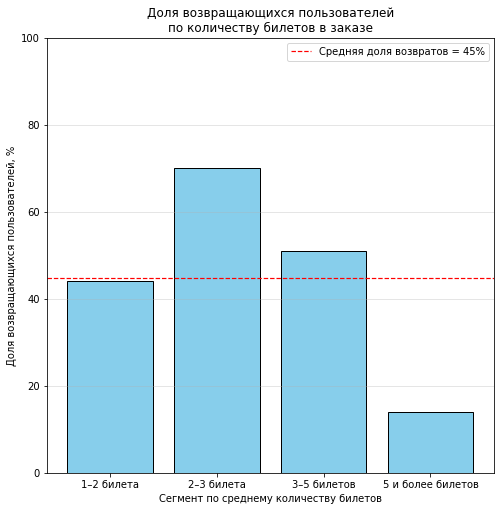

In [267]:
# Строим диаграмму распределения по сегментам
plt.figure(figsize=(8, 8))
plt.bar(segment_stats['tickets_segment'], segment_stats['share_return_users'] * 100, color='skyblue', edgecolor='black')
plt.title('Доля возвращающихся пользователей\nпо количеству билетов в заказе')
plt.xlabel('Сегмент по среднему количеству билетов')
plt.ylabel('Доля возвращающихся пользователей, %')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.4)

# Создаем переменную для среднего значения доли возвращающихся пользователей
avg_share_return = (segment_stats['share_return_users'] * 100).mean()

# Строим линию для визуализации среднего значения доли возвращающихся пользователей
plt.axhline(avg_share_return, color='red', linestyle='--', linewidth=1.2, label=f'Средняя доля возвратов = {avg_share_return:.0f}%')
plt.legend()
plt.show()

**Промежуточный вывод**

Распределение доли возвращающихся пользователей по сегментам неравномерное.

Наибольшая доля возвращающихся пользователей соответствует сегменту "2–3 билета" (70%, что можно считать аномально высоким значением, по сравнению со средним значением в 45%).

Меньше всего возвращающихся пользователей в сегменте "5 и более билетов" (14%, что можно считать аномально низким значением, по сравнению со средним значением в 45%).

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> У категории `3-5 билетов` должно быть `<5`, а у категории `5 и более билетов` должно быть `>=5`.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Выводы также нужно актуализировать.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделим день недели.

In [268]:
# Извлечём из даты первого заказа день недели
day_of_first_buy = filtered_user_profile['min_order_dt'].dt.day_name()

- Для каждого дня недели подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируем.

In [269]:
# Извлечём из даты первого заказа день недели
day_of_first_buy = filtered_user_profile['min_order_dt'].dt.day_name()

# Подсчитаем общее число пользователей для каждого дня недели
total_users_by_day = day_of_first_buy.value_counts()

# Определим пользователей, совершивших повторные заказы
repeated_users = filtered_user_profile[(filtered_user_profile['is_two'] == True) | (filtered_user_profile['is_five'] == True)]

# Группируем данные по дню недели и подсчитываем количество пользователей с повторными заказами
repeated_users_by_day = (
    repeated_users
    .groupby(day_of_first_buy)['user_id']
    .nunique()
)

# Рассчитаем долю пользователей с повторными заказами для каждого дня недели
repeated_users_ratio = repeated_users_by_day / total_users_by_day

# Вывод результатов
print('Общее число пользователей для каждого дня недели:')
display(total_users_by_day)

print('\nОбщее число пользователей с повторными заказами, для каждого дня недели:')
display(repeated_users_by_day)

print('\nДоля пользователей с повторными заказами для каждого дня недели:')
for day, ratio in repeated_users_ratio.items():
    print(f'{day}: {ratio:.2%}') 

Общее число пользователей для каждого дня недели:


Friday       3170
Saturday     3128
Tuesday      3036
Thursday     3022
Wednesday    2954
Monday       2814
Sunday       2640
Name: min_order_dt, dtype: int64


Общее число пользователей с повторными заказами, для каждого дня недели:


min_order_dt
Friday       1776
Monday       1660
Saturday     1820
Sunday       1469
Thursday     1674
Tuesday      1738
Wednesday    1722
Name: user_id, dtype: int64


Доля пользователей с повторными заказами для каждого дня недели:
Friday: 56.03%
Monday: 58.99%
Saturday: 58.18%
Sunday: 55.64%
Thursday: 55.39%
Tuesday: 57.25%
Wednesday: 58.29%


Text(0, 0.5, 'Доля пользователей, %')

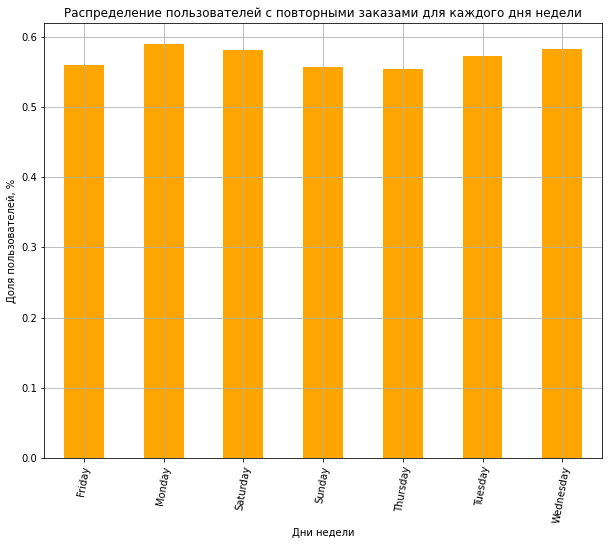

In [270]:
# Построим столбчатую диаграмму
plt.figure(figsize = (10, 8))

repeated_users_ratio.plot(kind = 'bar',
                   grid = True,
                   legend = False,                                        
                   color = 'orange',
                   rot = 80
)

plt.title('Распределение пользователей с повторными заказами для каждого дня недели')
plt.xlabel('Дни недели')
plt.ylabel('Доля пользователей, %')

**Промежуточный вывод**

Данные в таблице "Общее число пользователей для каждого дня недели" показывают заметную разницу в абсолютном количестве пользователей между днями, в частности, существенный спад в воскресенье по сравнению с пиком в пятницу.

Анализ доли пользователей с повторными заказами показывает, что этот показатель почти не меняется в течение недели - все значения находятся в очень узком диапазоне.

Таким образом, день недели, в которую была совершена первая покупка, не влияет на вероятность возврата клиента.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Итоговый вывод о том, что день недели, в которую была совершена первая покупка, не влияет на вероятность возврата клиента, является верной интерпретацией.

Анализ доли пользователей с повторными заказами действительно показывает, что этот показатель почти не меняется в течение недели - все значения находятся в очень узком диапазоне.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В первом предложении допущена неточность. Утверждается, что общее число пользователей (первая таблица) варьируется незначительно. Однако данные в этой таблице показывают заметную разницу в абсолютном количестве пользователей между днями, в частности, существенный спад в воскресенье по сравнению с пиком в пятницу.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Учтено
</div>

---

**Задача 4.3.2.** Изучим, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитаем среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.

In [271]:
# Создаем сегменты для двух групп пользователей (2-4 заказа и 5 и более заказов)
interval_profile = filtered_user_profile[['user_id', 'total_orders', 'average_time_between_orders']].copy()
interval_profile['order_group'] = pd.cut(interval_profile['total_orders'], bins=[1, 4, float('inf')], labels=['2–4 заказа', '5 и более заказов'], right=True)

# Рассчитываем средний интервал между заказами по группам
interval_stats = (interval_profile.groupby('order_group').agg(mean_interval=('average_time_between_orders', 'mean')).reset_index())

# Округляем средний интервал между заказами
interval_stats['mean_interval'] = (interval_stats['mean_interval']).round()

# Выводим результат
print(interval_stats)

         order_group  mean_interval
0         2–4 заказа           21.0
1  5 и более заказов           12.0


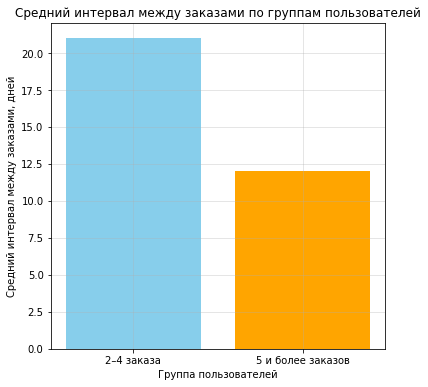

In [272]:
# Строим диаграмму распределения по среднему интервалу между заказами
plt.figure(figsize=(6, 6))
plt.bar(interval_stats['order_group'], interval_stats['mean_interval'], color=['skyblue', 'orange'])
plt.title('Средний интервал между заказами по группам пользователей')
plt.ylabel('Средний интервал между заказами, дней')
plt.xlabel('Группа пользователей')
plt.grid(alpha=0.4)
plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Аналогично нужно явно фильтровать по числу заказов. `is_two` - это `>2`, `is_five` - это `>5`, под наше условие не подходит.

<div class="alert alert-info">
<h2> Комментарий студента v.2<a class="tocSkip"> </h2>

Исправлено
</div>

**Промежуточный вывод**

Пользователи, совершающие 5 и более заказов, делают покупки значительно чаще (средний интервал между заказами - 12 дней), чем пользователи, совершающие 2–4 заказа (средний интервал между заказами - 21 день, почти вдвое больше).

Можно сделать вывод о том, что частота заказов напрямую связана с вероятностью повторной покупки.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:

- Рассчитаем коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.

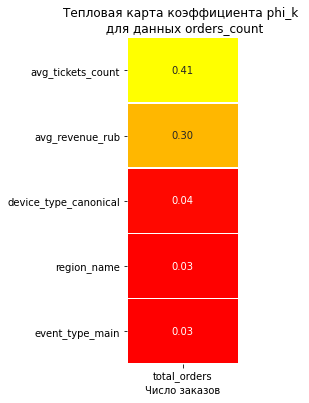

In [276]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = filtered_user_profile[['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'device_type_canonical', 'region_name', 'event_type_main']].phik_matrix(interval_cols=['total_orders', 'avg_revenue_rub', 'avg_tickets_count'])
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

# Cтроим тепловую карту
plt.figure(figsize=(2, 6))
sns.heatmap(data=data_heatmap, 
            annot=True, 
            cmap='autumn', 
            fmt='.2f', 
            linewidths=0.5,
            cbar=False)
plt.title('Тепловая карта коэффициента phi_k \n для данных orders_count')
plt.xlabel('Число заказов')
plt.show()

**Промежуточный вывод**

По тепловой карте коэффициента phi_k видно, что наибольшая связь между числом заказов и средним количеством билетов в заказе - 0,41, что соответствует умеренной положительной корреляционной связи. Это может быть связано с тем, что пользователи, которые в среднем покупают больше билетов за один заказ, чаще совершают повторные покупки.

Между числом заказов и средней выручкой слабая положительная корреляционная связь - 0,3. Возможно пользователи с более высокой средней выручкой в заказе имеют тенденцию быть более лояльными.

Между числом заказов и регионом, в котором совершен первый заказ, связи практически нет (0.04). У остальных признаков также, связи практически нет (0.03).

## 5. Общий вывод и рекомендации <a class="anchor" id="chapter5"></a>

* В Pandas были загружены данные датасета `data-analyst-afisha`, в которых представлена информация о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года. Датасет содержал 14 столбцов и 290610 строк. Данные содержат информацию о заказах билетов, событиях, городах и регионах событий, площадках мероприятий, о курсе тенге к российскому рублю за 2024 год (дополнительный датасет `final_tickets_tenge_df.csv`);


* При первичном знакомстве с данными и их предобработке выявили, что в одном столбце `days_since_prev` ~ 8%, образованы по причине отсутствия покупок у пользователей - оставлены без изменений, чтобы избежать искажения данных. По столбцам `revenue_rub` с выручкой и `tickets_count` с количеством билетов в заказе были отфильтрованы данные до 99-го перцентиля, исключив выбросы и сохранив репрезентативность. Явных дубликатов нет, не явные - 18.33% (удалены). Созданы новые столбцы: `revenue_rub` — выручка с заказа к единой валюте (российский рубль);

* В столбцах `revenue_rub` и `tickets_count` с численными данными обнаружены выбросы - аномальные максимальные значения, которые могут быть связаны с большими корпоративными заказами. Данные отфильтрованы - исключены выбросы по 99-му перцентилю. Количество отфильтрованных выбросов составило: 4.88%. Отфильтрованный датафрейм содержит 20764 строк;

* Построены агрегированные признаки, описывающие поведение и профиль каждого пользователя:
    * дата первого и последнего заказа;
    * устройство, с которого был сделан первый заказ;
    * регион, в котором был сделан первый заказ;
    * билетный партнёр, к которому обращались при первом заказе;
    * жанр первого посещённого мероприятия;
    * общее количество заказов;
    * средняя выручка с одного заказа в рублях;
    * среднее количество билетов в заказе;
    * среднее время между заказами;
    
* Добавлены два бинарных признака:
    * is_two — совершил ли пользователь 2 и более заказа;
    * is_five — совершил ли пользователь 5 и более заказов;
    
* Выполнена проверка репрезентативности данных. Анализ данных профиля пользователя показал:
    * Общее число пользователей: 20764
    * Средняя выручка с одного заказа: 542.98
    * Доля пользователей, совершивших более 2 заказов: 57.11%
    * Доля пользователей, совершивших более 5 заказов: 21.0%
    * Среднее общее число заказов: 25
    * Среднее число билетов в заказе: 2.74
    * Среднее количество дней между покупками: 9.96;

В ходе исследовательского анализа данных было выявлено:

* Анализ распределения пользователей по сегментам показал, что существует несколько ярко выраженных "точек входа" при совершении первого заказа:
    * основной тип первого мероприятия - концерты;
    * основное устройство для совершения первого заказа - мобильное;
    * региональная концентрация первых заказов - Каменевский регион;
    * лидер среди билетных операторов при совершении первого заказа - "Билеты без проблем". 
    
При планировании акций, рекомендаций и расширении охвата следует учитывать эти "точки входа", они могут быть связаны с массовостью и регулярностью проведения мероприятий, удобства использования мобильных устройств при совершении заказа, плотностью населения отдельных регионов и маркетинговой стратегией оператора-лидера.

* Анализ распределения возвращающихся пользователей по сегментам показал, что ярко выраженных "точек входа" нет, однако чаще совершают повторный заказ при следующих условиях:
    * основной тип первого мероприятия - выставки, театр, концерты;
    * основное устройство для совершения первого заказа - стационарное;
    * регион проведения мероприятий первых заказов - Шанырский регион и Светополянский округ. При этом регионы с низкой плотностью населения (с десятками пользователей) не учитывались для избежания статистической нестабильности долей;
    * лидеры среди билетных операторов при совершении первого заказа - "Край билетов" и "Дом культуры". При этом менее популярные операторы (с десятками пользователей) не учитывались для избежания статистической нестабильности долей.
    
* Анализ взаимосвязи между средней выручкой сервиса с заказа и повторными заказами показал:
    * зависимости между величиной средней выручки с билета и совершением повторных заказов нет;
    * существенных различий по средней выручке с заказа между группами "2-4 заказа" и "5 и более заказов" также нет - частота заказов не связана напрямую с размером среднего чека.
    
* Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки показал:
    * меньше всего возвращающихся пользователей в сегменте "5 и более билетов";
    * наибольшая доля возвращающихся пользователей соответствует сегменту "2–3 билета".
    
* Исследование временных характеристик первого заказа показало:
    * день недели, в который совершена первая покупка, не влияет на вероятность возврата клиента;
    * частота заказов напрямую связана с вероятностью повторной покупки (пользователи, совершающие 5 и более заказов, делают покупки значительно чаще, чем пользователи, совершающие не более 4 заказов).
    
Корреляционный анализ количества покупок и признаков пользователя показал, что число заказов пользователей сильнее всего связано с характеристиками их покупательской активности (количество билетов в заказе и средней выручкой).

**Рекомендации:**

Для стимулирования повторных заказов следует отправлять персональные предложения пользователям не позднее, чем через 10 дней после покупки (средний интервал повторной покупки пользователей сегмента "5 и более покупок"). 

Кроме того, следует обратить внимение на следующие "точки входа": театр и выставки, Шанырский и Светополянский регионы.

Для привлечения новых пользователей при проведении рекламных кампаний следует обратить внимание на выявленные "точки входа": концерты, заказ через мобильное устройство, Каменевский регион, сервис "Билеты без проблем".

Основной фокус следует направить на повышение частоты покупок, а не среднего чека.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Итоговый вывод корректно описывает ключевые результаты работы над проектом, тут всё отлично.

## 6. Финализация проекта и публикация в Git<a class="anchor" id="chapter6"></a>

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Ссылку на проект:**
https://github.com/PutilEl/Yandex_afisha_user_behavior

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Репозиторий корректно оформлен, параметры подключения загружаются из файла конфигурации. Можно также добавить файл `README.md` и продублировать там итоговый вывод.

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Елизавета, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)